# PEtab benchmark model with BayesFlow

In [ ]:
# pip install git+https://github.com/Benchmarking-Initiative/Benchmark-Models-PEtab.git@master#subdirectory=src/python
# pypesto, amici, petab, fides, joblib

In [ ]:
import os

if "KERAS_BACKEND" not in os.environ:
    os.environ["KERAS_BACKEND"] = "torch"
else:
    print(f"Using '{os.environ['KERAS_BACKEND']}' backend")

import numpy as np
import pandas as pd
import pickle
from joblib import Parallel, delayed
from typing import Union
from collections import defaultdict
import matplotlib.pyplot as plt

import benchmark_models_petab as benchmark_models
import petab
import pypesto.optimize as optimize
import pypesto.sample as sample
import pypesto.petab
import pypesto.visualize as visualize
from pypesto.visualize.model_fit import visualize_optimized_model_fit
from scipy import stats

import bayesflow as bf

import amici
import logging
amici.swig_wrappers.logger.setLevel(logging.CRITICAL)
pypesto.logging.log(level=logging.ERROR, name="pypesto.petab", console=True)

from petab_helper import scale_values, values_to_linear_scale, amici_df_to_array, amici_pred_to_df, create_pypesto_problem

USE_MALA = False

# print all model names
print(benchmark_models.MODELS)

In [ ]:
# generate petab problem
#job_id = int(os.environ.get('SLURM_ARRAY_TASK_ID', 0))
n_cpus = 10 #int(os.environ.get('SLURM_CPUS_PER_TASK', 1))
problem_name = "Beer_MolBioSystems2014" #"Beer_MolBioSystems2014", "Boehm_JProteomeRes2014"
storage = '' # f'plots/{problem_name}/'
petab_problem = benchmark_models.get_problem(problem_name)

# decrease upper bounds for offset, scaling and noise parameters
scale_params_id = [name for name in petab_problem.parameter_df.index.values if name[:6] == 'offset' or name[:5] == 'scale']
petab_problem.parameter_df.loc[scale_params_id, 'upperBound'] = 100  # instead of 1000
sd_params_id = [name for name in petab_problem.parameter_df.index.values if name[:3] == 'sd_']
petab_problem.parameter_df.loc[sd_params_id, 'upperBound'] = 10  # instead of 1000


# add normal prior (on scale) around real parameters values
real_data_params = petab_problem.parameter_df.nominalValue
std = 0.5
for i in real_data_params.index:
    if petab_problem.parameter_df.loc[i, 'estimate'] == 0:
        continue
    # set prior mean depending on scale
    mean = scale_values(real_data_params.loc[i], petab_problem.parameter_df.loc[i, 'parameterScale'])
    if not 'objectivePriorType' in petab_problem.parameter_df or pd.isna(petab_problem.parameter_df.loc[i, 'objectivePriorType']):
        petab_problem.parameter_df.loc[i, 'objectivePriorType'] = "parameterScaleNormal"
        petab_problem.parameter_df.loc[i, 'objectivePriorParameters'] = f"{mean};{std}"

for i, row in petab_problem.parameter_df.iterrows():
    if 'objectivePriorType' in row and not pd.isna(row['objectivePriorType']):
        if row['estimate'] == 0:
            print(f"Parameter {i} has a {row['objectivePriorType']} prior but is not estimated, setting to nan")
            petab_problem.parameter_df.loc[i, 'objectivePriorType'] = np.nan
        # validate petab problem, if scale for parameter is defined, prior must be on the same scale
        if row['parameterScale'] != 'lin' and not row['objectivePriorType'].startswith('parameterScale'):
            raise ValueError(f"Parameter {i} has parameterScale {row['parameterScale']} but {row['objectivePriorType']} prior")


importer = pypesto.petab.PetabImporter(petab_problem, simulator_type="amici")
factory = importer.create_objective_creator()

model = factory.create_model(verbose=False)
amici_predictor = factory.create_predictor()
amici_predictor.amici_objective.amici_solver.setAbsoluteTolerance(1e-8)

# Creating the pypesto problem from PEtab
pypesto_problem = importer.create_problem(
    startpoint_kwargs={"check_fval": True, "check_grad": True}
)
pypesto_problem.print_parameter_summary()

In [ ]:
def get_samples_from_dict(samples_dict):
    samples = np.stack([samples_dict[name][..., 0] for name in pypesto_problem.x_names], axis=-1)
    return samples

def prior():
    lb = petab_problem.parameter_df['lowerBound'].values
    ub = petab_problem.parameter_df['upperBound'].values
    param_names_id = petab_problem.parameter_df.index.values
    param_scale = petab_problem.parameter_df['parameterScale'].values
    if 'objectivePriorType' in petab_problem.parameter_df.columns:
        prior_type = petab_problem.parameter_df['objectivePriorType'].values
    else:
        prior_type = [np.nan] * len(param_names_id)
    estimate_param = petab_problem.parameter_df['estimate'].values

    prior_dict = {}
    for i, name in enumerate(param_names_id):
        if estimate_param[i] == 0:
            prior_dict[name] = petab_problem.parameter_df['nominalValue'].values[i]  # linear space
        elif prior_type[i] == 'uniform':  # linear space
            prior_dict[name] = np.random.uniform(low=lb[i], high=ub[i])
        elif prior_type[i] == 'parameterScaleUniform' or pd.isna(prior_type[i]):
            # scale bounds to scaled space
            lb_scaled_i = scale_values(lb[i], param_scale[i])
            ub_scaled_i = scale_values(ub[i], param_scale[i])
            val = np.random.uniform(low=lb_scaled_i, high=ub_scaled_i)
            # scale to linear space
            prior_dict[name] = values_to_linear_scale(val, param_scale[i])
        elif prior_type[i] == 'parameterScaleNormal':
            mean, std = petab_problem.parameter_df['objectivePriorParameters'].values[i].split(';')
            lb_scaled_i = scale_values(lb[i], param_scale[i])
            ub_scaled_i = scale_values(ub[i], param_scale[i])
            a, b = (lb_scaled_i - float(mean)) / float(std), (ub_scaled_i - float(mean)) / float(std)
            rv = stats.truncnorm.rvs(loc=float(mean), scale=float(std), a=a, b=b)
            # scale to linear space
            prior_dict[name] = values_to_linear_scale(rv, param_scale[i])
        elif prior_type[i] == 'normal':
            mean, std = petab_problem.parameter_df['objectivePriorParameters'].values[i].split(';')
            a, b = (lb[i] - float(mean)) / float(std), (ub[i] - float(mean)) / float(std)
            rv = stats.truncnorm.rvs(loc=float(mean), scale=float(std), a=a, b=b)
            prior_dict[name] = rv
        elif prior_type[i] == 'laplace':
            loc, scale = petab_problem.parameter_df['objectivePriorParameters'].values[i].split(';')
            for t in range(10):
                rv = np.random.laplace(loc=float(loc), scale=float(scale))
                if lb[i] <= rv <= ub[i]:  # sample from truncated laplace
                    break
            prior_dict[name] = rv
        else:
            raise ValueError("Unknown prior type:", prior_type[i])
        # scale params and make list
        prior_dict[name] = np.array([scale_values(prior_dict[name], param_scale[i])])

    # prepare variables for simulation
    x = get_samples_from_dict(prior_dict)
    prior_dict['amici_params'] = x  # scaled parameters for amici
    return prior_dict

def simulator_amici(amici_params, return_df=False):
    pred = amici_predictor(amici_params)  # expect amici_params to be scaled
    sim_df, failed = amici_pred_to_df(pred, amici_params,
                                      factory=factory, petab_problem=petab_problem, pypesto_problem=pypesto_problem)
    sim = amici_df_to_array(sim_df)
    if failed:
        sim = sim * np.nan  # set all to nan if simulation failed
    if return_df:
        return dict(sim_data=sim, sim_failed=failed, sim_data_df=sim_df)
    return dict(sim_data=sim, sim_failed=failed)

In [ ]:
prior_sample = prior()
test = simulator_amici(prior_sample['amici_params'], return_df=True)
test['sim_data'].shape, prior_sample['amici_params'].shape, np.nansum(test['sim_data'])

In [ ]:
#test = simulator_amici(prior_sample['amici_params'], return_df=True)
#compute_objective(petab_problem, test['sim_data_df'], prior_sample['amici_params'])

In [ ]:
# # plot prior
# n_rows = len(pypesto_problem.x_names) // 6
# n_cols = int(np.ceil(len(pypesto_problem.x_names) / n_rows))
# fig, axs = plt.subplots(n_rows, n_cols, figsize=(2*n_rows, 2*n_cols), layout='constrained')
# axs = axs.flatten()
# samples = [prior() for i in range(1000)]
# for i, name in enumerate(pypesto_problem.x_names):
#     samples_i = np.array([s[name] for s in samples]).flatten()
#     axs[i].hist(samples_i, density=True)
#     axs[i].set_title(name)
#     # axs[i].axvline(scale_values(petab_problem.parameter_df['nominalValue'][i],
#     #                              petab_problem.parameter_df['parameterScale'][i]), color='red', linestyle='--')
#     # axs[i].axvline(scale_values(petab_problem.parameter_df['lowerBound'][i],
#     #                             petab_problem.parameter_df['parameterScale'][i]), color='blue', linestyle='--')
#     # axs[i].axvline(scale_values(petab_problem.parameter_df['upperBound'][i],
#     #                             petab_problem.parameter_df['parameterScale'][i]), color='blue', linestyle='--')
# plt.show()

In [ ]:
def run_mcmc(petab_problem, data_df=None, n_optimization_starts=0, n_chains=10, n_samples=10000,
             n_procs=10, use_mala=True, verbose=False, mix_start=0.75) -> Union[pypesto.result.Result, tuple[pypesto.result.Result, petab.Problem, pypesto.Problem]]:
    if data_df is None:
        # use true data
        _pypesto_problem = create_pypesto_problem(petab_problem)
        _petab_problem = None
    else:
        _measurement_df = data_df
        if not 'measurement' in _measurement_df.columns:
            _measurement_df['measurement'] = _measurement_df['simulation']  # pypesto expects measurement column
        _pypesto_problem, _petab_problem = create_pypesto_problem(petab_problem, _measurement_df)

    if n_optimization_starts == 0:
        print("Skipping optimization, sample start points for chains from prior")
        _result = None
        x0 = [_pypesto_problem.get_reduced_vector(prior()['amici_params']) for _ in range(n_chains)]
    else:
        # do the optimization
        _result = optimize.minimize(
            problem=_pypesto_problem,
            optimizer=optimize.FidesOptimizer(verbose=0),
            #optimizer=optimize.ScipyOptimizer(method='L-BFGS-B'),
            n_starts=n_optimization_starts,
            engine=pypesto.engine.MultiProcessEngine(n_procs=n_procs) if n_procs > 1 else None,
            progress_bar=verbose
        )
        x0 = [_pypesto_problem.get_reduced_vector(_result.optimize_result.x[0])]
        x0 = [mix_start*np.array(x0[0]) + (1-mix_start)*_pypesto_problem.get_reduced_vector(prior()['amici_params'])]
        if x0[0] is None:
            print("Warning: x0 contains nan, replace with prior sample")
            x0[0] = _pypesto_problem.get_reduced_vector(prior()['amici_params'])
        x0 += [_pypesto_problem.get_reduced_vector(prior()['amici_params']) for _ in range(n_chains - 1)]

    _sampler = sample.AdaptiveParallelTemperingSampler(
        internal_sampler=sample.MalaSampler() if use_mala else sample.AdaptiveMetropolisSampler(),
        n_chains=n_chains,
        options=dict(show_progress=verbose)
    )

    _result = sample.sample(
        problem=_pypesto_problem,
        n_samples=n_samples,
        sampler=_sampler,
        result=_result,
        x0=x0
    )
    sample.geweke_test(_result)

    if data_df is None:
        return _result
    return _result, _petab_problem, _pypesto_problem

In [ ]:
def get_mcmc_posterior_samples(res):
    burn_in = sample.geweke_test(res)
    if burn_in == res.sample_result.trace_x.shape[1]:
        print("Warning: All samples are considered burn-in.")
        _samples = res.sample_result.trace_x[0]  # only use first chain
    else:
        _samples = res.sample_result.trace_x[0, burn_in:]  # only use first chain
    #_samples = pypesto_problem.get_full_vector(_samples)
    #scales = petab_problem.parameter_df.loc[res.problem.x_names, 'parameterScale'].values
    #_samples = values_to_linear_scale(_samples, scales)
    return _samples

In [ ]:
n_optimization_starts = 1
test_params = prior()
test = simulator_amici(prior_sample['amici_params'], return_df=True)
#print(test_params)
new_result, new_petab_problem, new_pypesto_problem = run_mcmc(
    petab_problem=petab_problem,
    data_df=test['sim_data_df'],
    n_optimization_starts=n_optimization_starts,
    n_samples=1e2,
    n_procs=n_cpus,
    n_chains=2,
    verbose=True
)

if n_optimization_starts > 0:
    visualize.waterfall(new_result, size=(6, 4))
    visualize.parameters(new_result, size=(6, 25))
    sim_dict = visualize_optimized_model_fit(
        petab_problem=new_petab_problem,
        result=new_result,
        pypesto_problem=new_pypesto_problem,
        return_dict=True
    )
    print(test_params['amici_params']-new_result.optimize_result.x[0])

    fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(10, 3), layout='constrained')
    obs_name = ['Bac', 'Ind']
    for i, obs_id in enumerate(sim_dict['simulation_df']['observableId'].unique()):
        df_obs = sim_dict['simulation_df'][sim_dict['simulation_df']['observableId'] == obs_id]
        for j, sim_con in enumerate(df_obs['simulationConditionId'].unique()):
            df = df_obs[df_obs['simulationConditionId'] == sim_con]
            ax[i].plot(df['time'].values, df['simulation'].values[:, 0], 'o', markersize=0.7, label=f'Condition {j}')
        ax[i].set_ylabel(f'{obs_name[i]} [a.u.]')
        ax[i].set_xlabel('Time [min]')
    #fig.legend(labels=[f'Cond{i+1}' for i in range(16)], bbox_to_anchor=(0.5, -0.3), loc='lower center', ncols=6)
    #plt.savefig(f'petab_benchmark_model_{problem_name}.png')
    plt.show()

visualize.sampling_fval_traces(new_result)
ax = visualize.sampling_parameter_traces(new_result)
ax = ax.flatten()
test_val = pypesto_problem.get_reduced_vector(test_params['amici_params'])
for i in range(new_pypesto_problem.dim):
    ax[i].axhline(test_val[i], color='red', linestyle='--')
print(np.mean((test_val-np.median(get_mcmc_posterior_samples(new_result), axis=0))**2))

In [ ]:
# n_optimization_starts = 20
# result = run_mcmc(
#     petab_problem=petab_problem,
#     pypesto_problem=pypesto_problem,
#     n_optimization_starts=n_optimization_starts,
#     n_samples=1e3
# )
#
# if n_optimization_starts > 0:
#     visualize.waterfall(result, size=(6, 4))
#     visualize.parameters(result, size=(6, 25))
#     visualize_optimized_model_fit(petab_problem=petab_problem, result=result, pypesto_problem=pypesto_problem);

In [ ]:
#ax = visualize.sampling_parameter_traces(result, size=(20, 20), full_trace=False, use_problem_bounds=False);
#visualize.sampling_scatter(result, size=(13, 6));

# Generate training and validation data

In [ ]:
from model_settings import MODELS, NUM_SAMPLES_INFERENCE, load_model

num_training_sets = 512 * 64
num_validation_sets = 1000

In [ ]:
@delayed
def sample_and_simulate(return_df=False):
    """Single iteration of sampling and simulation"""
    prior_sample = prior()
    test = simulator_amici(prior_sample['amici_params'], return_df=return_df)

    # Combine both dictionaries
    result = {**prior_sample, **test}
    return result


def simulate_parallel(n_samples, return_df=False):
    """Parallel sampling and simulation"""
    results = Parallel(n_jobs=n_cpus, verbose=100)(
        sample_and_simulate(return_df) for _ in range(n_samples)
    )
    results_dict = defaultdict(list)

    for r in results:
        for key, value in r.items():
            results_dict[key].append(value)
    for key, value_list in results_dict.items():
        if isinstance(value_list[0], pd.DataFrame):
            pass
        else:
           results_dict[key] = np.array(value_list)
    return results_dict

In [ ]:
if os.path.exists(f"{storage}validation_data_petab_{problem_name}.pkl"):
    with open(f'{storage}validation_data_petab_{problem_name}.pkl', 'rb') as f:
        validation_data = pickle.load(f)
    try:
        with open(f'{storage}training_data_petab_{problem_name}.pkl', 'rb') as f:
            training_data = pickle.load(f)
    except FileNotFoundError:
        training_data = None
        print("Training data not found")
else:
    training_data = simulate_parallel(num_training_sets)
    validation_data = simulate_parallel(num_validation_sets, return_df=True)

    with open(f'{storage}training_data_petab_{problem_name}.pkl', 'wb') as f:
        pickle.dump(training_data, f)
    with open(f'{storage}validation_data_petab_{problem_name}.pkl', 'wb') as f:
        pickle.dump(validation_data, f)

# remove failed simulations
if not training_data is None:
    train_mask = ~training_data['sim_failed']
    for key in training_data.keys():
        training_data[key] = training_data[key][train_mask]
    print(f"Failed Training data: {np.sum(~train_mask)} / {len(train_mask)}")
val_mask = ~validation_data['sim_failed']
for key in validation_data.keys():
    if key == 'sim_data_df':
        continue
    validation_data[key] = validation_data[key][val_mask]
print(f"Failed Validation data: {np.sum(~val_mask)} / {len(val_mask)}")

test_mean = np.nanmean(np.log(validation_data['sim_data'] + 1), axis=(0, 1), keepdims=True)
test_std = np.nanstd(np.log(validation_data['sim_data'] + 1), axis=(0, 1), keepdims=True)
print(validation_data['sim_data'].shape)

param_names = [name for i, name in enumerate(pypesto_problem.x_names) if i in pypesto_problem.x_free_indices]
lbs = np.array([lb for i, lb in enumerate(petab_problem.lb_scaled) if i in pypesto_problem.x_free_indices])
ubs = np.array([ub for i, ub in enumerate(petab_problem.ub_scaled) if i in pypesto_problem.x_free_indices])

# MCMC workflow

In [ ]:
def run_mcmc_single(petab_prob, pypesto_prob, sim_data_df, n_starts,
                    n_mcmc_samples, n_final_samples, n_chains, use_mala):
    import amici
    import logging
    amici.swig_wrappers.logger.setLevel(logging.CRITICAL)
    pypesto.logging.log(level=logging.ERROR, name="pypesto.petab", console=True)

    if all(np.isnan(sim_data_df['simulation'])):
        return np.full((n_final_samples, len(pypesto_prob.x_free_indices)), np.nan)

    r, _, _ = run_mcmc(
        petab_problem=petab_prob,
        data_df=sim_data_df,
        n_optimization_starts=n_starts,
        n_samples=n_mcmc_samples,
        n_chains=n_chains,
        n_procs=1,
        use_mala=use_mala
    )

    if r is None:
        return np.full((n_final_samples, len(pypesto_prob.x_free_indices)), np.nan)

    ps = get_mcmc_posterior_samples(r)
    # num_samples random samples from posterior
    idx = np.random.choice(ps.shape[0], size=n_final_samples)
    return ps[idx]

In [ ]:
mcmc_path = f'{storage}mcmc_samples_{problem_name}{"_mala" if USE_MALA else ""}.pkl'
if os.path.exists(mcmc_path):
    with open(mcmc_path, 'rb') as f:
        mcmc_posterior_samples = pickle.load(f)
else:
    mcmc_posterior_samples = Parallel(n_jobs=n_cpus, verbose=10)(
        delayed(run_mcmc_single)(
            petab_prob=petab_problem,
            pypesto_prob=pypesto_problem,
            sim_data_df=sim_data_df,
            n_starts=10,
            n_mcmc_samples=1e5,
            n_final_samples=1000,
            n_chains=10,
            use_mala=USE_MALA
        ) for sim_data_df in validation_data['sim_data_df']
    )
    mcmc_posterior_samples = np.array(mcmc_posterior_samples)

    with open(mcmc_path, 'wb') as f:
        pickle.dump(mcmc_posterior_samples, f)
mcmc_mask = ~np.isnan(mcmc_posterior_samples.sum(axis=(1, 2)))
mcmc_posterior_samples_test = mcmc_posterior_samples[val_mask]

In [ ]:
fig = bf.diagnostics.recovery(
    estimates=mcmc_posterior_samples_test[mcmc_mask],
    targets=pypesto_problem.get_reduced_vector(validation_data['amici_params'].T).T[mcmc_mask],
    variable_names=param_names,
)
#fig.savefig(f"{storage}petab_benchmark_{problem_name}_mcmc_recovery.png")

fig = bf.diagnostics.calibration_ecdf(
    estimates=mcmc_posterior_samples_test[mcmc_mask],
    targets=pypesto_problem.get_reduced_vector(validation_data['amici_params'].T).T[mcmc_mask],
    variable_names=param_names,
    difference=True,
    stacked=True
)
#fig.savefig(f"{storage}petab_benchmark_{problem_name}_mcmc_calibration.png")

# BayesFlow workflow

In [15]:
adapter = (
    bf.adapters.Adapter()
    .drop('amici_params')  # only used for simulation
    .drop('sim_data_df')
    .to_array()
    .convert_dtype("float64", "float32")
    .concatenate(param_names, into="inference_variables")
    .constrain("inference_variables", lower=lbs, upper=ubs, inclusive='both')  # after concatenate such that we can apply an array as constraint

    .as_time_series("sim_data")
    .log("sim_data", p1=True)
    #.standardize("sim_data", mean=test_mean, std=test_std)
    #.nan_to_num("sim_data", default_value=-3.0)
    .rename("sim_data", "summary_variables")
)

In [ ]:
# # check how the distributions look like
# test_params = adapter.forward(validation_data)['inference_variables']
#
# n_rows = len(param_names) // 6
# n_cols = int(np.ceil(len(param_names) / n_rows))
# fig, ax = plt.subplots(n_rows, n_cols, figsize=(2*n_rows, 2*n_cols), layout='constrained')
# ax = ax.flatten()
# for i, name in enumerate(param_names):
#     samples = test_params[:, i]
#     ax[i].hist(samples, density=True)
#     ax[i].set_title(name)
# plt.show()

In [ ]:
# check how the data distribution looks like (disable nan_to_num in adapter to see nans)
_test_data = adapter.forward(validation_data)['summary_variables']
# n_features = _test_data.shape[-1]
#
# n_rows = n_features // 5
# n_cols = int(np.ceil(n_features / n_rows))
# fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_rows, 2*n_cols))
# ax = ax.flatten()
# for i in range(n_features):
#     ax[i].hist(_test_data[:, :, i].flatten(), density=True)
# plt.show()

In [ ]:
# print some stats about the data
print('Minimum', np.min(_test_data))
print('Maximum', np.max(_test_data))
print('Mean', np.mean(_test_data))
print('Standard Deviation', np.std(_test_data))
print('Nan Values', np.isnan(_test_data).sum())

In [ ]:
model_name = list(MODELS.keys())[6]
conf_tuple = MODELS[model_name]
print(model_name)

In [ ]:
%%time
workflow = load_model(adapter=adapter, conf_tuple=conf_tuple, param_names=param_names,
                      training_data=validation_data, #todo: training_data,
                      #use_ema=True,
                      validation_data=validation_data, storage=f'{storage}models/',
                      problem_name=problem_name, model_name=model_name)

In [ ]:
diagnostics_plots = workflow.plot_default_diagnostics(test_data=validation_data,
                                                      num_samples=NUM_SAMPLES_INFERENCE,
                                                      #approximator_kwargs=dict(method='rk45', steps=100),
                                                      calibration_ecdf_kwargs={"difference": True, 'stacked': True})
#for k in diagnostics_plots.keys():
#    diagnostics_plots[k].savefig(f"{storage}petab_benchmark_{problem_name}_{model_name}_{k}.png")

# Compare MCMC and Diffusion models

In [16]:
from bayesflow.diagnostics.metrics import root_mean_squared_error, posterior_contraction, calibration_error, classifier_two_sample_test
from visualize_results import plot_model_comparison_radar
from petab_helper import compute_likelihood

In [17]:
test_data = {}
for key, values in validation_data.items():
    if key == 'sim_data_df':
        test_data[key] = values
    else:
        test_data[key] = values[val_mask]

In [18]:
no_ema = False  # set to True, to get the noema model to validate training

In [19]:
for fusion_transformer_summary in [False, True]:
    metrics = []
    for i in range(len(MODELS)):
        if fusion_transformer_summary and not 'ft' in list(MODELS.keys())[i]:
            continue
        elif not fusion_transformer_summary and 'ft' in list(MODELS.keys())[i]:
            continue
        if os.path.exists(f'{storage}metrics/petab_benchmark_{problem_name}_metrics_{i}.pkl'):
            if no_ema and 'ema' in list(MODELS.keys())[i]:
                with open(f'{storage}metrics/petab_benchmark_{problem_name}_metrics_{i}_noema.pkl', 'rb') as f:
                    metric = pickle.load(f)
            else:
                with open(f'{storage}metrics/petab_benchmark_{problem_name}_metrics_{i}.pkl', 'rb') as f:
                    metric = pickle.load(f)
            metrics += metric
        else:
            print(f"Metrics for model {list(MODELS.keys())[i]} not found")

    # df, all columns to float beside model and sampler
    metrics_df = pd.DataFrame(metrics, index=None)
    for col in ['nrmse', 'posterior_contraction', 'posterior_calibration_error', 'c2st']:
        metrics_df[col] = metrics_df[col].astype(float)
        metrics_df.loc[metrics_df[col].isna(), col] = 1

    # add mcmc as baseline
    if os.path.exists(f'{storage}metrics/petab_benchmark_{problem_name}_mcmc_{"_mala" if USE_MALA else ""}metrics.csv'):
        with open(f'{storage}metrics/petab_benchmark_{problem_name}_mcmc_{"_mala" if USE_MALA else ""}metrics.csv', 'rb') as f:
            mcmc_df = pd.read_csv(f, index_col=0)
        metrics_df = pd.concat([metrics_df, mcmc_df], ignore_index=True)
    else:
        print('Adding MCMC metrics')
        test_targets = get_samples_from_dict(test_data)

        rand_idx = np.random.choice(mcmc_posterior_samples_test.shape[1])
        obj_val = np.zeros((len(test_data['sim_data_df']), 1))
        for i in range(len(test_data['sim_data_df'])):
            obj_val[i] = np.nan
            if mcmc_mask[i]:
                obj_val[i] = compute_likelihood(petab_problem, test_data['sim_data_df'][i], mcmc_posterior_samples_test[i, rand_idx])
        workflow_samples_aug = np.concatenate((mcmc_posterior_samples_test[mcmc_mask, rand_idx], obj_val[mcmc_mask]), axis=-1)

        # augment test data
        obj_val = np.zeros((len(test_data['sim_data_df']), 1))
        for i in range(len(test_data['sim_data_df'])):
            obj_val[i] = compute_likelihood(petab_problem, test_data['sim_data_df'][i], test_data['amici_params'][i])
        test_data_aug = np.concatenate((test_data['amici_params'], obj_val), axis=-1)

        mcmc_df = pd.DataFrame([{
            'model': 'MCMC',
            'sampler': 'MCMC',
            'nrmse': root_mean_squared_error(mcmc_posterior_samples_test[mcmc_mask], test_targets[mcmc_mask])['values'].mean(),
            'nrmse_std': root_mean_squared_error(mcmc_posterior_samples_test[mcmc_mask], test_targets[mcmc_mask],
                                                 normalize='std')['values'].mean(),
            'posterior_contraction': posterior_contraction(mcmc_posterior_samples_test[mcmc_mask], test_targets[mcmc_mask])['values'].mean(),
            'posterior_calibration_error': calibration_error(mcmc_posterior_samples_test[mcmc_mask], test_targets[mcmc_mask])['values'].mean(),
            'c2st': classifier_two_sample_test(workflow_samples_aug, test_data_aug, validation_split=0.2)
        }], index=[0])
        with open(f'{storage}metrics/petab_benchmark_{problem_name}_mcmc_metrics.csv', 'wb') as f:
            mcmc_df.to_csv(f)
        metrics_df = pd.concat([metrics_df, mcmc_df], ignore_index=True)

    metrics_df.loc[metrics_df['nrmse'] == 1.0, 'posterior_contraction'] = 0.0  # samples were nan
    metrics_df.loc[metrics_df['nrmse_std'] == 1.0, 'posterior_contraction'] = 0.0  # samples were nan
    metrics_df['rank'] = metrics_df['nrmse'] + metrics_df['posterior_calibration_error']
    #metrics_df['rank'] = metrics_df['nrmse_std'] + metrics_df['posterior_calibration_error']
    metrics_df = metrics_df[metrics_df['sampler'] != 'sde-pc']
    metrics_df = metrics_df[metrics_df['model'] != 'stable_consistency_model']
    metrics_df = metrics_df[metrics_df['model'] != 'stable_consistency_model_ft']
    metrics_df['c2st'] = 0.5+np.abs(metrics_df['c2st']-0.5)

    if fusion_transformer_summary:
        metrics_df_2 = metrics_df.copy()
    else:
        metrics_df_1 = metrics_df.copy()
        metrics_df_joint = metrics_df.copy()

    display(metrics_df.sort_values(by='rank', inplace=False))

,model,sampler,nrmse,nrmse_std,posterior_contraction,posterior_calibration_error,c2st,rank
0,flow_matching,ode,0.148280,0.7437568848297631,0.735785,0.056568,0.700000,0.204848
2,ot_flow_matching,ode,0.146049,0.7330490606965968,0.733670,0.063099,0.775000,0.209149
17,diffusion_cosine_v,ode,0.151924,0.7622853526073633,0.729073,0.058304,0.525000,0.210228
6,diffusion_edm_vp,sde,0.157308,0.7881595881129635,0.691232,0.059466,0.600000,0.216774
12,diffusion_edm_ve,sde,0.134959,0.6760036703846395,0.854866,0.082357,0.625000,0.217316
5,diffusion_edm_vp,ode,0.165585,0.8295329090823864,0.667220,0.052398,0.700000,0.217983
8,diffusion_edm_vp_ema,ode,0.171005,0.8564799618886784,0.590773,0.048867,0.675000,0.219872
15,diffusion_cosine_F,sde,0.150328,0.7536415596289789,0.730625,0.070727,0.625000,0.221055
18,diffusion_cosine_v,sde,0.150997,0.7575161558261172,0.728271,0.073092,0.525000,0.224089
9,diffusion_edm_vp_ema,sde,0.168395,0.843428936834132,0.594401,0.056546,0.575000,0.224941


,model,sampler,nrmse,nrmse_std,posterior_contraction,posterior_calibration_error,c2st,rank
2,ot_flow_matching_ft,ode,0.155001,0.777361983598451,0.694145,0.046122,0.625000,0.201123
0,flow_matching_ft,ode,0.155823,0.7809064010104964,0.695847,0.055263,0.550000,0.211086
15,diffusion_cosine_F_ft,sde,0.161281,0.8083261262183442,0.690439,0.055095,0.625000,0.216376
6,diffusion_edm_vp_ft,sde,0.165637,0.8302414070154136,0.672563,0.050874,0.675000,0.216511
18,diffusion_cosine_v_ft,sde,0.160415,0.8036753252662007,0.691674,0.056937,0.675000,0.217352
17,diffusion_cosine_v_ft,ode,0.162515,0.814203069795833,0.689762,0.055263,0.650000,0.217778
9,diffusion_edm_vp_ft_ema,sde,0.166708,0.8358326364568396,0.671967,0.053304,0.675000,0.220012
14,diffusion_cosine_F_ft,ode,0.168206,0.8429928394787715,0.668493,0.056290,0.575000,0.224496
5,diffusion_edm_vp_ft,ode,0.175666,0.8805382931994692,0.644128,0.049839,0.650000,0.225505
1,flow_matching_edm_ft,ode,0.168043,0.8424001557649959,0.650358,0.059667,0.500000,0.227710


In [20]:
for m in ['nrmse', 'nrmse_std', 'posterior_contraction', 'posterior_calibration_error', 'c2st', 'rank']:
    metrics_df_joint[m] = (metrics_df_1[m] + metrics_df_2[m]) / 2
metrics_df_joint.sort_values(by='rank', inplace=False)

,model,sampler,nrmse,nrmse_std,posterior_contraction,posterior_calibration_error,c2st,rank
2,ot_flow_matching,ode,0.150525,0.7552055221475239,0.713908,0.054611,0.700000,0.205136
0,flow_matching,ode,0.152052,0.7623316429201297,0.715816,0.055916,0.625000,0.207967
17,diffusion_cosine_v,ode,0.157219,0.7882442112015982,0.709417,0.056784,0.587500,0.214003
6,diffusion_edm_vp,sde,0.161472,0.8092004975641885,0.681897,0.055170,0.637500,0.216642
15,diffusion_cosine_F,sde,0.155805,0.7809838429236615,0.710532,0.062911,0.625000,0.218716
18,diffusion_cosine_v,sde,0.155706,0.780595740546159,0.709973,0.065015,0.600000,0.220721
5,diffusion_edm_vp,ode,0.170626,0.8550356011409278,0.655674,0.051118,0.675000,0.221744
9,diffusion_edm_vp_ema,sde,0.167551,0.8396307866454857,0.633184,0.054925,0.625000,0.222476
8,diffusion_edm_vp_ema,ode,0.173963,0.8717085580454906,0.615545,0.051619,0.650000,0.225583
14,diffusion_cosine_F,ode,0.162627,0.815288192401735,0.691569,0.063342,0.537500,0.225969


In [38]:
#plot_model_comparison_radar(metrics_df_joint, group_by_sampler=True, save_path=f'plots')
#plot_model_comparison_radar(metrics_df_joint, group_by_method='diffusion', save_path=f'plots')

ode


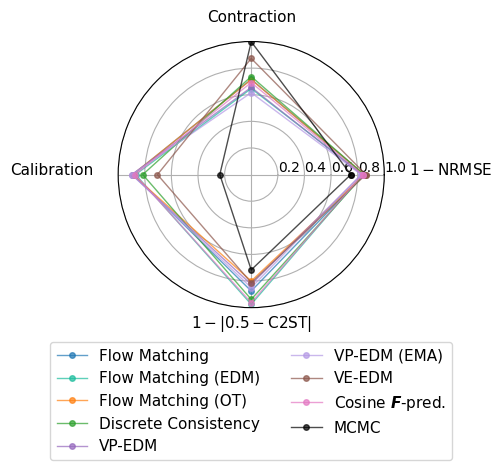

sde


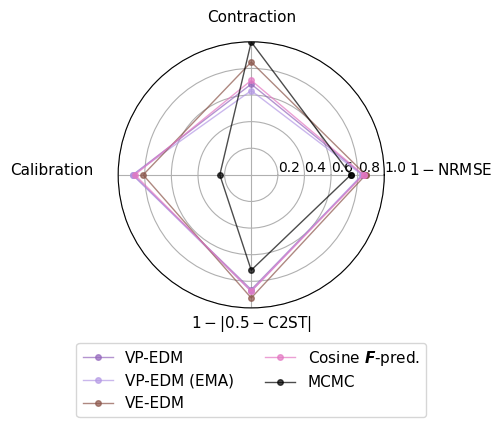

In [39]:
plot_model_comparison_radar(metrics_df_joint,
                            group_by_method='overview',
                            group_by_sampler=True, save_path=f'plots')

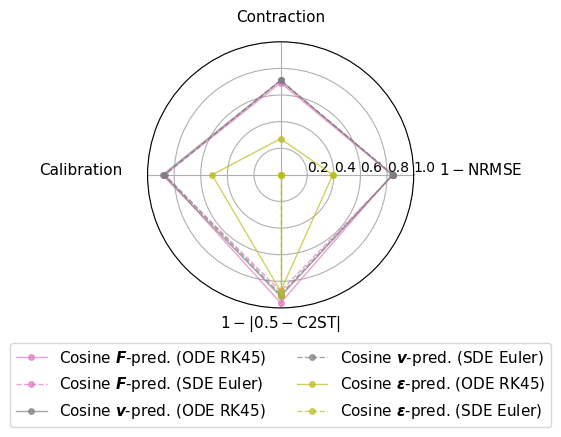

In [41]:
plot_model_comparison_radar(metrics_df_joint, group_by_method='cosine', save_path=f'plots')

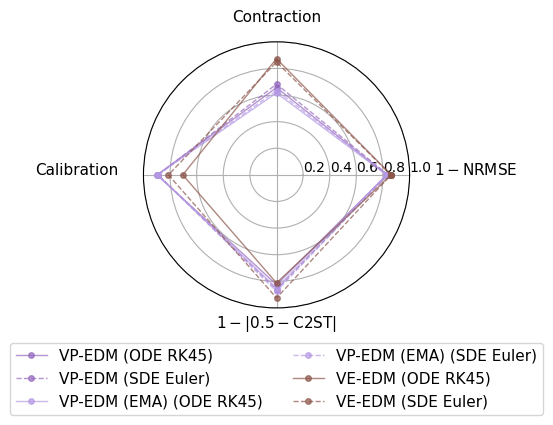

In [42]:
plot_model_comparison_radar(metrics_df_joint, group_by_method='edm', save_path=f'plots')